## Install Packages

In [15]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu117
0.15.2+cu117


## Import 

# Setup

In [4]:
import torch
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
import torch.nn as nn 

In [5]:
CLASSIFIER =  nn.Sequential(
        nn.Dropout(p=0.5, inplace=False),
            nn.Linear(2084, 1500)
            #nn.ReLU(),
            #nn.BatchNorm1d(1024),
            #nn.Dropout(p=0.5, inplace=False),
            #nn.Linear(1024, num_classes)
            #nn.ReLU(),
            #nn.BatchNorm1d(512),
            #nn.Dropout(p=0.3, inplace=False),
            #nn.Linear(512, num_classes),
            #nn.ReLU(),
            #nn.BatchNorm1d(num_classes),
            #nn.Dropout(p=0.3, inplace=True)
        )

In [7]:
class Resnet101(nn.Module):
    def __init__(self, classifier, pretrained, fine_tune):
        super(Resnet101, self).__init__()
        self.model = models.resnet101(pretrained=pretrained)
                # Remove the original fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Remove the last layer
        
        self.classifier = CLASSIFIER

        model_name = self.__class__.__name__
        print(f"Model: {model_name}")
        print(f'[INFO]: Number of infeatures:{num_features}')
        if fine_tune:
            print('[INFO]: Fine-tuning all layers...')
            for params in model.parameters():
                params.requires_grad = True
        elif not fine_tune:
            print('[INFO]: Freezing hidden layers...')
            self.freeze_layers()
        
    def forward(self, x):
        # Extract features from the base model
        x = self.model(x)  # Here, x will be the output from the average pooling layer
        # Flatten the features
        x = torch.flatten(x, 1)
        # Pass features through the new classifier layers
        x = self.classifier(x)
        return x
    
    def freeze_layers(self):
        # Freeze layers except for 'layer3', 'layer4', and 'classifier_layer'
        for name, child in self.model.named_children():
            if name in ['layer3', 'layer4']:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False 
            
        for params in self.classifier.parameters():
            params.requires_grad = True 

In [9]:
model = models.resnet101(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
import math
class CustomLRScheduler:
    def __init__(self, optimizer, warmup_epochs, stop_lr, total_epochs, base_lr, final_lr):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.stop_lr = stop_lr
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.final_lr = final_lr
        self.current_epoch = 0

    def step(self, epoch):
        self.current_epoch = epoch
        if epoch < self.warmup_epochs:
            lr = self.base_lr * (epoch / self.warmup_epochs)
        elif epoch < self.total_epochs - self.stop_lr:
            lr = self.final_lr + (self.base_lr - self.final_lr) * 0.5 * (1 + math.cos(math.pi * (epoch - self.warmup_epochs) / (self.total_epochs - self.stop_lr - self.warmup_epochs)))
        else:
            lr = self.final_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def get_last_lr(self):
        return [self.optimizer.param_groups[0]['lr']]

In [4]:
def set_scheduler(config: dict, optimizer: torch.optim.Optimizer):
    scheduler = config['Scheduler']
    if scheduler:
        print(f'[INFO]: Setting Scheduler: {scheduler["Name"]}..')
        if scheduler['Name'] == 'StepLR':
            return StepLR(optimizer, step_size=scheduler['step_size'], gamma=scheduler['gamma'])
        elif scheduler['Name'] == 'CustomLRScheduler':
            return CustomLRScheduler(optimizer, warmup_epochs=scheduler['Warmup_Epochs'], stop_lr=scheduler['Stop_LR'], total_epochs=config['Num_Epochs'], base_lr=scheduler['Base_LR'], final_lr=scheduler['Final_LR'])
        elif scheduler['Name'] == 'ReduceLROnPlateau':
            return ReduceLROnPlateau(optimizer, 'min')
        elif scheduler['Name'] == 'CosineAnnealingLR':
            return CosineAnnealingLR(optimizer, T_max=scheduler['Warmup_Epochs'])
        
    print(f'[INFO]: No Scheduler used..')
    return None

In [5]:
cinfig = {
    'Data_Path': 'Datasets/Clothes/', 
    'Save_To': 'models',
    'Split_Size': 0.8, 
    'Models': ['Resnet50', 'EfficientNetB7', 'Vgg16'],
    'Fine_Tune': False,
    'Pretrained': True,
    'Num_Epochs': 100, 
    'Batch_size': 24, 
    'Optimizer': {
       'Name': 'SGD',
        'lr': 0.0001,
        'weight_decay':0.01,
        'momentum': 0.9
    },
    'Loss_Function': 'CrossEntropyLoss',
    'label_smoothing': 0.1,
    'Scheduler': {
       'Name': 'CosineAnnealingLR', 
        #'Name': 'StepLR', CustomLRScheduler, ReduceLROnPlateau, CosineAnnealingLR
        'step_size': 10, 
        'gamma': 0.1, 
        'Warmup_Epochs': 5, 
        'Stop_LR': 10, 
        'Base_LR': 5e-3, 
        'Final_LR': 1e-5
    },
    'EarlyStopping': {
        'Patience': 10, 
        'min_delta': 0, 
        'verbose': True
    }
}

model = models.vgg16(pretrained=True)
optimizer = optim.Adam(model.parameters(), lr=0.001, )

/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
scheduler=set_scheduler(cinfig, optimizer)

[INFO]: Setting Scheduler: CosineAnnealingLR..


In [7]:
results = []
for epoch in range(6):
    if scheduler:
        if isinstance(scheduler, CustomLRScheduler):
            scheduler.step(epoch+1)
            print("CustomLRScheduler")
        elif isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(epoch/100)
            print("ReduceLROnPlateau")
        else:
            scheduler.step()
            print("others")
                # Log the learning rates
        if hasattr(scheduler, 'get_last_lr'):
            current_lrs = scheduler.get_last_lr()[0]
        else:
            current_lrs = optimizer.param_groups[0]['lr']
            print(current_lrs)
    results.append(current_lrs)
    print(f"[INFO] LR: {current_lrs}")
print(results)

others
[INFO] LR: 0.0009045084971874737
others
[INFO] LR: 0.0006545084971874737
others
[INFO] LR: 0.00034549150281252633
others
[INFO] LR: 9.549150281252633e-05
others
[INFO] LR: 0.0
others
[INFO] LR: 9.549150281252627e-05
[0.0009045084971874737, 0.0006545084971874737, 0.00034549150281252633, 9.549150281252633e-05, 0.0, 9.549150281252627e-05]


/opt/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [ ]:
# Ensure autoreload is enabled
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
from pathlib import Path
from time import sleep
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchinfo import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torchmetrics import ConfusionMatrix
from torch.optim.lr_scheduler import ExponentialLR
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import time
import copy
from utilities.helper import save_model, get_num_correct, create_target_dir, create_dir

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def set_scheduler(config: dict, optimizer: torch.optim.Optimizer):
    scheduler = config['Scheduler']
    if scheduler:
        print(f'[INFO]: Setting Scheduler: {scheduler["Name"]}..')
        if scheduler['Name'] == 'StepLR':
            return StepLR(optimizer, step_size=scheduler['step_size'], gamma=scheduler['gamma'])
        elif scheduler['Name'] == 'CustomLRScheduler':
            return CustomLRScheduler(optimizer, warmup_epochs=scheduler['Warmup_Epochs'], stop_lr=scheduler['Stop_LR'], total_epochs=config['Num_Epochs'], base_lr=scheduler['Base_LR'], final_lr=scheduler['Final_LR'])
        elif scheduler['Name'] == 'ReduceLROnPlateau':
            return ReduceLROnPlateau(optimizer, 'min')
        elif scheduler['Name'] == 'CosineAnnealingLR':
            return CosineAnnealingLR(optimizer, T_max=scheduler['Warmup_Epochs'])
        elif scheduler['Name'] == 'CyclicLR':
            return CyclicLR(optimizer, base_lr=scheduler['Base_LR'], max_lr=scheduler['Stop_LR'], step_size_up=scheduler['Warmup_Epochs'], mode='triangular')
        
    print(f'[INFO]: No Scheduler used..')
    return None

In [3]:
from functools import partial
import os
import tempfile
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.utils.data import random_split

In [4]:
import torch
import numpy as np
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Use a fixed seed value

In [5]:
## Unzip the data 

In [6]:
class Vgg16(nn.Module):
    def __init__(self, num_classes, pretrained=True, fine_tune=True):
        super(Vgg16, self).__init__()
        self.model = models.vgg16(pretrained=pretrained)
        
        # Freeze layers if not fine-tuning
        if not fine_tune:
            for param in self.model.parameters():
                param.requires_grad = False
            
        # Modify the classifier
        num_features = self.model.classifier[6].in_features
        self.model.classifier = nn.Identity()
        self.classifier = nn.Sequential(
                            nn.Linear(num_features, 4096),
                            nn.ReLU(True),
                            nn.Dropout(p=0.5),
                            nn.Linear(4096, 4096),
                            nn.ReLU(True),
                            nn.Dropout(p=0.5),
                            nn.Linear(4096, num_classes),
                        )

        print(f"Model: {self.__class__.__name__}")
        print(f'[INFO]: Number of in_features: {num_features}')
        if fine_tune:
            print('[INFO]: Fine-tuning all layers...')
            for params in self.model.parameters():
                params.requires_grad = True
        else:
            print('[INFO]: Freezing hidden layers...')
            self.freeze_layers()
        
    def forward(self, x):
        # Extract features from the base model
        x = self.model(x)  # Here, x will be the output from the average pooling layer
        #print(f'Shape after model: {x.shape}') 
        # Flatten the features
        x = torch.flatten(x, 1)
        # Pass features through the new classifier layers
        x = self.classifier(x)
        return x
    
    def freeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False
        for i in [26, 28]:
            for param in self.model.features[i].parameters():
                param.requires_grad = True
        for param in self.classifier.parameters():
            param.requires_grad = True

In [7]:
model = Vgg16(num_classes=287, pretrained=True, fine_tune=True)

Model: Vgg16
[INFO]: Number of in_features: 4096
[INFO]: Fine-tuning all layers...


In [8]:
print(summary(model))

Layer (type:depth-idx)                   Param #
Vgg16                                    --
├─VGG: 1-1                               --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  36,928
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  73,856
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  147,584
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 295,168
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 590,080
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 590,080
│    │    └─ReLU: 3-16                   --
│    │    └─MaxPool2d: 3-17              --
│    │    └─Conv2d: 3-18                

In [20]:
for name, param in model.named_parameters():
    print(f"{name} - requires_grad: {param.requires_grad}")

model.features.0.weight - requires_grad: True
model.features.0.bias - requires_grad: True
model.features.2.weight - requires_grad: True
model.features.2.bias - requires_grad: True
model.features.5.weight - requires_grad: True
model.features.5.bias - requires_grad: True
model.features.7.weight - requires_grad: True
model.features.7.bias - requires_grad: True
model.features.10.weight - requires_grad: True
model.features.10.bias - requires_grad: True
model.features.12.weight - requires_grad: True
model.features.12.bias - requires_grad: True
model.features.14.weight - requires_grad: True
model.features.14.bias - requires_grad: True
model.features.17.weight - requires_grad: True
model.features.17.bias - requires_grad: True
model.features.19.weight - requires_grad: True
model.features.19.bias - requires_grad: True
model.features.21.weight - requires_grad: True
model.features.21.bias - requires_grad: True
model.features.24.weight - requires_grad: True
model.features.24.bias - requires_grad: T

In [5]:
CURRENT_DIR = os.getcwd()
#DATA_DIR = 'Datasets/Clothes'
#PATH_TO_DATA =  os.path.join(CURRENT_DIR,DATA_DIR)
#print(PATH_TO_DATA)

In [6]:
DATA_DIR = Path('Datasets/Clothes')

DATA_DIR

PosixPath('Datasets/Clothes')

# Visualize an image

In [7]:
import random
from PIL import Image

# set seed
#random.seed(42)
# Get all image paths 
image_path_list = list(DATA_DIR.glob('*/*.jpg'))
 
# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name 
image_class = random_image_path.parent.stem

# Open Image
img = Image.open(random_image_path)

Random image path: Datasets/Clothes/BAC/69.jpg
Image class: BAC
Image height: 256
Image width: 256
Image color_channels: 3


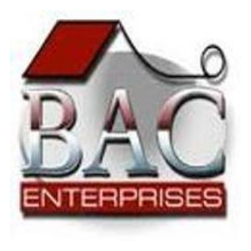

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
print(f"Image color_channels: {img_as_array.shape[2]}")
# Turn the image into an array

# Plot the image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_as_array)
plt.axis(False);

In [9]:
import torch
print("Number of CUDA devices available:", torch.cuda.device_count())

num_workers = os.cpu_count()
print(num_workers)

Number of CUDA devices available: 1
24


In [10]:
class PadTensor(object):
    def __init__(self, padding):
        # Padding can be a single integer or a tuple (left, right, top, bottom)
        self.padding = padding  

    def __call__(self, tensor):
        # Pad the tensor and specify the padding mode
        # 'constant' mode adds constant valued padding, and 0 is the padding value
        return torch.nn.functional.pad(tensor, self.padding, mode='constant', value=0)

## Data augmentaion and normalizaion

In [11]:
# Create transform function
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(p=0.5), # data augmentation
    #transforms.RandomRotation(45),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    #transforms.Lambda(lambda image: image.convert('RGB')),
    #transforms.RandomRotation(85),
    #transforms.Grayscale(num_output_channels=3),
    #transforms.GaussianBlur(kernel_size = (7,13), sigma = (6 , 7)),
    #transforms.ColorJitter(brightness=(0.5,1.5),contrast=(2),saturation=(1.4),hue=(-0.1,0.5)),
    transforms.ToTensor(),
    #PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std) # normalization
])
transforms_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.CenterCrop((224, 224)),
    #transforms.RandomRotation(45),
    transforms.ToTensor(),
    #PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std)
])

data_transforms = {
    'train': transforms_train,
    'valid': transforms_valid,
}

In [12]:
transforms_train(img).shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


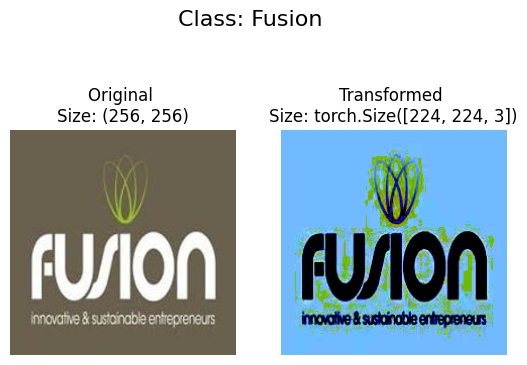

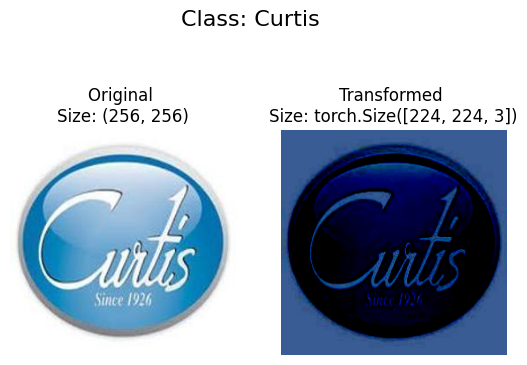

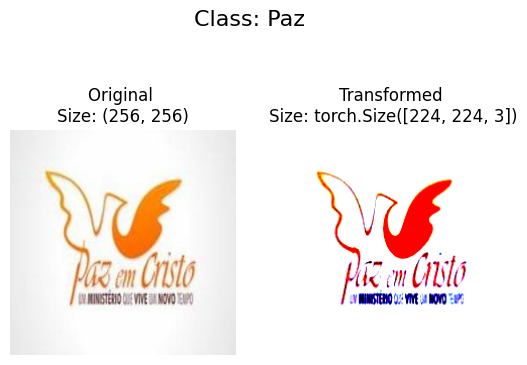

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=transforms_train, 
                        n=3)

In [14]:
from typing import Tuple, Dict, List
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

## Load Data

## Set up path for data after downloading

In [15]:
from torch.utils.data import random_split
from sklearn.model_selection import KFold
# Load the dataset

# Ensure all files are valid images
def is_valid_file(path):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
    return os.path.splitext(path)[1].lower() in valid_extensions

# Load the dataset with valid file checker
try:
    dataset = datasets.ImageFolder(DATA_DIR, is_valid_file=is_valid_file, transform=None)
    print("Dataset loaded successfully.")
    
    random.seed(42)
    # Split the dataset into train and test sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, test_size])

    # Apply different transforms to train and test datasets using a custom Dataset
    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, transform=None):
            self.dataset = dataset
            self.transform = transform

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            image, label = self.dataset[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

    # Create datasets with appropriate transformations
    train_dataset = CustomDataset(train_dataset, transform=transforms_train)
    valid_dataset = CustomDataset(valid_dataset, transform=transforms_valid)
except Exception as e:
    print(f"Error loading dataset: {e}")
#dataset = datasets.ImageFolder(DATA_DIR, transform=None)

Dataset loaded successfully.


In [16]:
print(len(train_dataset))
print(len(valid_dataset))

16450
4113


In [17]:
img, label = train_dataset[0]

In [18]:
train_dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
    Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
)

In [19]:
batch_size = 24


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                               num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Valid dataset size:', len(valid_dataset))
class_names = dataset.classes
#print('Class names:', class_names)

num_classes = len(class_names)
print('Class numbers:', num_classes)
print()
print('Train dataloader size (number of batches):', len(train_dataloader))
print('Valid dataloader size (number of batches):', len(valid_dataloader))
print('Train dataset size:', len(train_dataloader.dataset))
print('Valid dataset size::', len(valid_dataloader.dataset))

Train dataset size: 16450
Valid dataset size: 4113
Class numbers: 287

Train dataloader size (number of batches): 686
Valid dataloader size (number of batches): 172
Train dataset size: 16450
Valid dataset size:: 4113


#  Visualize data after transformation

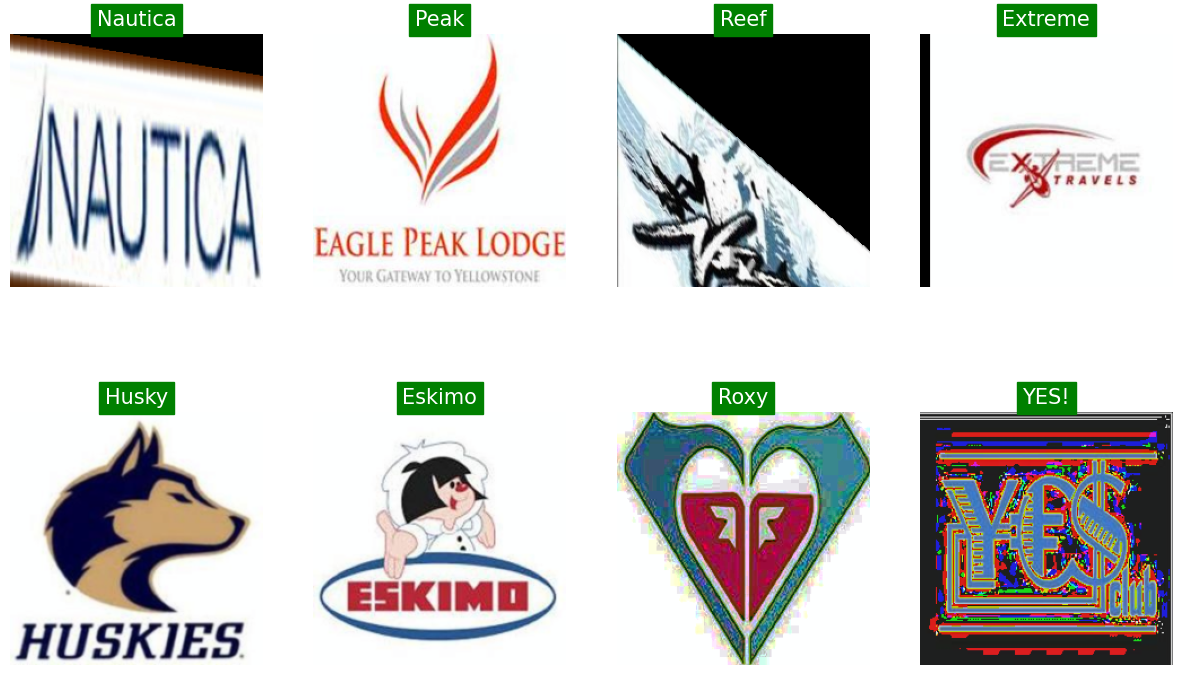

In [20]:
fig = plt.figure(figsize=(15,9))
rows, cols = 2, 4

# Load a batch of train images
iterator = iter(train_dataloader)
inputs, classes = next(iterator)
def imshow(input, title, ax):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    ax.imshow(input)
    ax.set_title(title, fontsize=15, color='white', backgroundcolor='green')
    ax.axis('off')  # Hide axes

# Loop through the first 8 images in the batch
for i in range(1, 9):
    ax = fig.add_subplot(rows, cols, i)
    # Display each image in its subplot
    imshow(inputs[i - 1], class_names[classes[i - 1]], ax)

plt.show()

## Load pre-trained ResNet-18 model 

In [21]:
class Resnet50(nn.Module):
    def __init__(self, num_classes, pretrained, fine_tune):
        super(Resnet50, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
                # Remove the original fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Remove the last layer
        
        # Assuming the features output from Resnet50 is of size 2048
        self.classifier_layer = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(num_features, 1024),
            #nn.ReLU(),
            nn.BatchNorm1d(1024),
            #nn.Dropout(p=0.3, inplace=False),
            nn.Linear(1024, 512),
            #nn.ReLU(),
            nn.BatchNorm1d(512),
            #nn.Dropout(p=0.2, inplace=False),
            nn.Linear(512, num_classes),
            #nn.ReLU(),
            nn.BatchNorm1d(num_classes),
            #nn.Dropout(p=0.3, inplace=False)
        )
        model_name = self.__class__.__name__
        print(f"Model: {model_name}")
        print(f'[INFO]: Number of infeatures:{num_features}')
        if fine_tune:
            print('[INFO]: Fine-tuning all layers...')
            for params in model.parameters():
                params.requires_grad = True
        elif not fine_tune:
            print('[INFO]: Freezing hidden layers...')
            self.freeze_layers()
        
    def forward(self, x):
        # Extract features from the base model
        x = self.model(x)  # Here, x will be the output from the average pooling layer
        # Flatten the features
        x = torch.flatten(x, 1)
        # Pass features through the new classifier layers
        x = self.classifier_layer(x)
        return x
    
    def freeze_layers(self):
        # Freeze layers except for 'layer3', 'layer4', and 'classifier_layer'
        for name, child in self.model.named_children():
            if name in ['layer3', 'layer4']:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False 
            
        for params in self.classifier_layer.parameters():
            params.requires_grad = True

In [22]:
class Resnet18(nn.Module):
    def __init__(self, num_classes, pretrained, fine_tune):
        super(Resnet18, self).__init__()
        self.model = models.resnet18(pretrained=pretrained)
                # Remove the original fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Remove the last layer
        # Assuming the features output from Resnet50 is of size 2048
        self.classifier_layer = nn.Sequential(
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(num_features, num_classes),
            nn.BatchNorm1d(num_classes),
            #nn.Linear(128, num_classes)
            # nn.LogSoftmax(dim=1)
            #nn.ReLU(),  # Optional: Add if you want to add non-linearity
            #nn.Softmax(dim=1)  # Optional: Add if you need probabilities
        )
        
    
        model_name = self.__class__.__name__
        print(f"Model: {model_name}")
        print(f'[INFO]: Number of infeatures:{num_features}')
        if fine_tune:
            print('[INFO]: Fine-tuning all layers...')
            for params in self.model.parameters():
                params.requires_grad = True
        elif not fine_tune:
            print('[INFO]: Freezing hidden layers...')
            self.freeze_layers()
        
    def forward(self, x):
        # Extract features from the base model
        x = self.model(x)  # Here, x will be the output from the average pooling layer
        # Flatten the features
        x = torch.flatten(x, 1)
        # Pass features through the new classifier layers
        x = self.classifier_layer(x)
        return x
    
    def freeze_layers(self):
        # Freeze layers except for 'layer3', 'layer4', and 'classifier_layer'
        for name, child in self.model.named_children():
            if name in ['layer3', 'layer4']:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False 
            
        for params in self.classifier_layer.parameters():
            params.requires_grad = True  

In [23]:
#model = Resnet18(num_classes=num_classes, pretrained=True, fine_tune=False)
model = Resnet50(num_classes=num_classes, pretrained=True, fine_tune=False)

Model: Resnet50
[INFO]: Number of infeatures:2048
[INFO]: Freezing hidden layers...


In [24]:
model.classifier_layer

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=512, out_features=287, bias=True)
  (6): BatchNorm1d(287, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [25]:
# Custom learning rate scheduler
import math
class CustomLRScheduler:
    def __init__(self, optimizer, warmup_epochs, stop_lr, total_epochs, base_lr, final_lr):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.stop_lr=stop_lr
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.final_lr = final_lr
        self.current_epoch = 0

    def step(self, epoch):
        self.current_epoch = epoch
        if epoch < self.warmup_epochs:
            lr = self.base_lr * (epoch / self.warmup_epochs)
        elif epoch < self.total_epochs - self.stop_lr:
            lr = self.final_lr + (self.base_lr - self.final_lr) * 0.5 * (1 + math.cos(math.pi * (epoch - self.warmup_epochs) / (self.total_epochs - 10 - self.warmup_epochs)))
        else:
            lr = self.final_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

In [26]:
class EarlyStopping:
    def __init__(self,checkpoint_path, patience=7, min_delta=0, verbose=False):
        """
        Args:
            patience (int): How long to wait after the last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            target_dir (str): Path for the checkpoint to be saved to.
            verbose (bool): If True, prints a message for each validation loss improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.checkpoint_path = checkpoint_path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        """
        Args:
            val_loss (float): Current validation loss.
            model (torch.nn.Module): Model to save if validation loss decreases.
        """
        # Check if validation loss improved
        if val_loss < self.val_loss_min - self.min_delta:
            self.save_checkpoint(val_loss, model)
            self.val_loss_min = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'[INFO] EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """
        Saves model when validation loss decrease.
        """
        if self.verbose:
            print(f'[INFO] Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        save_model(model=model, target_dir=checkpoint_path, model_name=f'checkpoint_{self.counter}.pth')

In [27]:
from utilities.helper import save_model, create_target_dir

SAVE_MODEL_TO = 'models'
target_dir =create_target_dir(SAVE_MODEL_TO)

In [28]:
checkpoint_path= create_dir(path=target_dir, dir_name="Checkpoints" )

# Adam vs AdamW 

Adam: Commonly used for many tasks, but may require careful tuning of weight decay to avoid negative interactions with learning rates.
AdamW: Preferred when weight decay is important for regularization, 
    #as it offers a more straightforward implementation and often better performance.
while Adam includes weight decay within the gradient update, 
AdamW separates the weight decay from the adaptive learning process, 
providing potentially better performance and stability in training.

A high weight decay value like 50 is quite large and will impose a strong penalty on large weights, 
which might significantly influence the training process. 
Usually, weight decay values are set much lower (e.g., 0.01 or 0.001) 
to balance between reducing overfitting and maintaining the ability to learn useful features.

# useful
https://deci.ai/blog/resnet50-how-to-achieve-sota-accuracy-on-imagenet/

https://deci.ai/blog/knowledge-distillation-introduction/

https://deci.ai/blog/tricks-training-neural-networks/    

In [29]:
from torch.optim import lr_scheduler
from timm.data.mixup import Mixup
#model.fc = nn.Sequential(
#    nn.Dropout(0.5), 
#    nn.Linear(num_features, num_classes)
#    )
# Move the model to the GPU if available

lr = 5e-3
num_epochs = 300
patience = 12
label_smoothing=0.1
warmup_epochs=5
stop_lr = 10
base_lr=5e-3
final_lr=1e-5
momentum = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Loss functions
#criterion_kd = nn.KLDivLoss()
#criterion_ce = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(target_dir, patience=patience, min_delta=0, verbose=True)
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing) #label_smoothing=0.1 # weight=class_weights_tensor


# I can use other optimizers like adam
#optimizer = FusedLAMB(model.parameters(), lr=5e-3)
#optimizer = optim.AdamW(model.parameters(), lr=0.000025, weight_decay=0.001)
optimizer = optim.Adam(model.parameters(), lr=lr)# Use all parameters
# Optimizers to compare ##TODO
#optimizers = {
#    'SGD': optim.SGD(model.parameters(), lr=lr, momentum=0.9),
#    'Adam': optim.Adam(model.parameters(), lr=0.0001),
#    'RMSprop': optim.RMSprop(model.parameters(), lr=0.0001)
    # Add any other optimizers you want to compare
#}

exp_lr_scheduler = CustomLRScheduler(optimizer, warmup_epochs=warmup_epochs, stop_lr=stop_lr, total_epochs=num_epochs, base_lr=base_lr, final_lr=final_lr)
##exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#mixup_fn = Mixup(mixup_alpha=0.2, cutmix_alpha=1.0, cutmix_minmax=None, prob=1.0, switch_prob=0.5, mode='batch', label_smoothing=0.1, num_classes=num_classes)


#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

cuda:0


In [30]:
not isinstance(exp_lr_scheduler, CustomLRScheduler)

False

In [31]:
import json
def print_config(config: dict):
	print(json.dumps(config, indent=4))
         # Summary

config = {
    'Data_Path':'Datasets/Clothes/', 'Target_Dir':'models',
    'Split_Size': 0.8, 'Model': 'Resnet50', 'Fine_Tune': False,
    'Pretrained':True,
    'Num_Epochs': 100, 'Batch_size':24,
    'Optimizer':'Adam', 'Loss_Function': 'CrossEntropyLoss',
	'Scheduler': {'Name':'StepLR', 'step_size': 10, 'gamma': 0.1},
    'Learning_Rate': 0.001, 'Momentum': 0.9
    
}
print_config(config)

{
    "Data_Path": "Datasets/Clothes/",
    "Target_Dir": "models",
    "Split_Size": 0.8,
    "Model": "Resnet50",
    "Fine_Tune": false,
    "Pretrained": true,
    "Num_Epochs": 100,
    "Batch_size": 24,
    "Optimizer": "Adam",
    "Loss_Function": "CrossEntropyLoss",
    "Scheduler": {
        "Name": "StepLR",
        "step_size": 10,
        "gamma": 0.1
    },
    "Learning_Rate": 0.001,
    "Momentum": 0.9
}


In [32]:
import json
settings = { 'num_epochs': num_epochs, 'batch_size':batch_size, "EarlyStopping_patience":patience,
            'criterion': 'CrossEntropyLoss', 'momentum':momentum , 'label_smoothing':label_smoothing,
             'optimizer': 'Adam', 'lr': lr, 'warmup_epochs':warmup_epochs , 'stop_lr':stop_lr , 
            'base_lr':base_lr, 'final_lr':final_lr
}

with open(f'{target_dir}/settings.json', 'w') as file:
    json.dump(settings, file)

# TENSORBOARD

In [33]:
#train_loader = train_dataloader
#valid_loader = dataloaders['valid']

In [34]:
def train_model(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         scheduler,
         device: torch.device):
    model.to(device)
    # training mode
    model.train()
    print('Training...')
    train_loss , train_corrects = 0.0  , 0 
    y_pred = []
    y_true = []
        # loop through the training batches..
    for batch, (inputs, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        
        optimizer.zero_grad()
        # forward inputs and get output
        outputs = model(inputs)

        # Calculate loss (per batch)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item() * inputs.size(0)
            
        
        loss.backward()

        optimizer.step()
        
         # Calculate Accuracy
        _, preds = torch.max(outputs.data, 1)
        train_corrects += get_num_correct(preds, labels)
                # Extend 
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

        #if batch % 100 == 0:
            #print(f'Looked at {batch * len(inputs)}/{len(data_loader.dataset)} samples.')
                

    #scheduler.step()    
    avg_train_loss = train_loss / len(data_loader.dataset)
    avg_train_acc = train_corrects / len(data_loader.dataset) * 100
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    # Print progress
    return avg_train_loss, avg_train_acc, weighted_f1

In [35]:
def valid_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.to(device)
    model.eval()
    print('Validation...')
    val_loss = 0.0
    val_corrects = 0
    y_pred = []
    y_true = []
    for batch, (inputs, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        # Calculate loss (per batch)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        
         # Calculate Accuracy
        _, preds = torch.max(outputs.data, 1)
        val_corrects += get_num_correct(preds, labels)
        
        # Extend 
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    avg_valid_loss = val_loss / len(data_loader.dataset)
    avg_valid_acc = val_corrects / len(data_loader.dataset) * 100

    # Calculate the weighted F1 score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    return [avg_valid_loss, avg_valid_acc, y_pred, y_true, weighted_f1]

## Train the model on custom data 

In [36]:
model.classifier_layer

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=512, out_features=287, bias=True)
  (6): BatchNorm1d(287, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [37]:
from contextlib import contextmanager


@contextmanager
def log_stdout_to_file(filepath):
    # Save the current stdout and stderr so we can restore them later
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    try:
        # Open the log file in append mode
        with open(filepath, 'a') as file:
            # Define a helper function to handle the output
            def write_to_both(text):
                old_stdout.write(text)  # Write to standard output
                file.write(text)        # Write to file

            # Create a class that overrides the write and flush methods
            class SplitOutput:
                def write(self, message):
                    write_to_both(message)

                def flush(self):
                    old_stdout.flush()
                    file.flush()

            # Set this new output class as the current stdout and stderr
            sys.stdout = sys.stderr = SplitOutput()
            yield
    finally:
        # Restore the original stdout and stderr
        sys.stdout = old_stdout
        sys.stderr = old_stderr

In [38]:
# Initialize best accuracy and initialize model weights
class_names = dataset.classes
num_classes = len(class_names)

#batch_size = 32

# train
epoch_train_loss=[]
train_accuracy=[]
train_weighted_f1=[]
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]

best_acc = 0.0
y_pred = []
y_true = []

tb = SummaryWriter()
images, labels = next(iter(train_dataloader))
images, labels = images.to(device), labels.to(device)
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(model, images)
with log_stdout_to_file(f'{target_dir}/experiment_log.txt'):
    print(f"[INFO]: Number of training images: {len(train_dataset)}")
    print(f"[INFO]: Number of validation images: {len(valid_dataset)}")
    print(f"[INFO]: NUmber of Classes: {len(class_names)}\n")

        # Setup target device  
    print(f"Computation device: {device}")
    print(f"Learning rate: {lr}")
    print(f"Batch Size: {batch_size}")
    print(f"Epochs to train for: {num_epochs}\n")
    print(summary(model, input_size=(32,3,224,224)))
    print(f'\nclassifier_layer: {model.classifier_layer}\n')
start_time = time.time()
# Start Training loop
for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
            #print("Epoch {}/{} running....".format(epoch+1, num_epochs)) #(printing message)    
    """ Training Phase """
    exp_lr_scheduler.step(epoch+1)
    avg_train_loss, avg_train_acc, weighted_f1 = train_model(model, train_dataloader, loss_fn, optimizer,exp_lr_scheduler, device)
        # Append result
    epoch_train_loss.append(avg_train_loss)
    train_accuracy.append(avg_train_acc)
    train_weighted_f1.append(weighted_f1)
        
        # Tensorboard
    tb.add_scalar('Training Loss', avg_train_loss ,epoch)
    tb.add_scalar('Training Accuracy', avg_train_acc ,epoch)
    tb.add_scalar('Training F1 Score', weighted_f1 ,epoch)


    """ Validation Phase """
    history = valid_model(model, valid_dataloader, loss_fn, device)
    #exp_lr_scheduler.step(history[1])
    # Append result
    valid_loss.append(history[0])
    valid_accuracy.append(history[1])
    valid_weighted_f1.append(history[4])
    y_pred.extend(history[2])
    y_true.extend(history[3])
        
        # Tensorboard
    tb.add_scalar('Validation Loss', history[0] ,epoch)
    tb.add_scalar('Validation Accuracy', history[1] ,epoch)
    tb.add_scalar('Validation F1 Score', history[4] ,epoch)
        
    #tb.add_histogram('fc.Linear.bias', model.fc[8].bias, epoch)
    #tb.add_histogram('fc.Linear.weight', model.fc[8].weight, epoch)
    #tb.add_histogram('fc.Linear.weight.grad', model.fc[8].weight.grad, epoch)
    print(f'[INFO] LR: {exp_lr_scheduler.get_lr():.6f}')    
    print('[INFO] Training Loss: {:.4f} | Acc: {:.4f}% | Weighted F1: {:.4f}'.format(avg_train_loss, avg_train_acc, weighted_f1))
    print('[INFO] Validation Loss: {:.4f} | Acc: {:.4f}% | Weighted F1: {:.4f}'.format(history[0], history[1], history[4]))
    early_stopping(history[0], model)
    if early_stopping.early_stop:
        print("Early stopping....")
        print('-'*80)
        time.sleep(3)
        break
    # Save the best model
    if history[1] > best_acc:
        best_acc = history[1]
        print('Improvement-Detected, Best model updated')
        save_model(model=model, target_dir=target_dir, model_name='best_model.pth')
    print('-'*80)
    time.sleep(3)
with log_stdout_to_file(f'{target_dir}/experiment_log.txt'):
    save_model(model=model, target_dir=target_dir, model_name='last_model.pth')
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}%'.format(best_acc))

[INFO]: Number of training images: 16450
[INFO]: Number of validation images: 4113
[INFO]: NUmber of Classes: 287

Computation device: cuda:0
Learning rate: 0.005
Batch Size: 24
Epochs to train for: 300

Layer (type:depth-idx)                        Output Shape              Param #
Resnet50                                      [32, 287]                 --
├─ResNet: 1-1                                 [32, 2048]                --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         (70,400)
│    │    └─Bottlenec

100%|██████████| 686/686 [00:53<00:00, 12.92it/s]


Validation...


100%|██████████| 172/172 [00:11<00:00, 14.81it/s]


[INFO] LR: 0.001000
[INFO] Training Loss: 5.7710 | Acc: 0.9970% | Weighted F1: 0.4110
[INFO] Validation Loss: 5.7878 | Acc: 1.3372% | Weighted F1: 0.2798
[INFO] Validation loss decreased (inf --> 5.787830).  Saving model ...
[INFO] Saving model to: models/2024-06-09_23:11/Checkpoints/checkpoint_0.pth
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-09_23:11/best_model.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 2 of 300
Training...


  1%|          | 5/686 [00:00<02:02,  5.56it/s]


KeyboardInterrupt: 

## Ploting

In [ ]:
from utilities import visual
history = {
    'train_loss': epoch_train_loss,
    'valid_loss': valid_loss,
    'train_acc': train_accuracy,
    'valid_acc': valid_accuracy,
    'best_accuracy': best_acc, 
    'train_weighted_f1': train_weighted_f1,
     'valid_weighted_f1': valid_weighted_f1,
    'best_f1_score':best_f1_score

}

title = 'Performance'
visual.plot_results(history,target_dir, title)

In [40]:
 # Should print something like (286, 286) if there are 286 classes
print(len(class_names))

287


In [41]:
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]
y_pred = []
y_true = []
model = Resnet50(num_classes=num_classes, pretrained=True, fine_tune=False)
model.load_state_dict(torch.load(f'{target_dir}/best_model.pth'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
history_val = valid_model(model, valid_dataloader, loss_fn, device)
        # Append result
y_pred.extend(history_val[2])
y_true.extend(history_val[3])

Model: Resnet50
[INFO]: Number of infeatures:2048
[INFO]: Freezing hidden layers...
Validation...


100%|██████████| 172/172 [00:12<00:00, 14.20it/s]


In [42]:
print('Weighted F1: {:.4f}'.format(history_val[4]))

Weighted F1: 67.7138


In [43]:
print("Accuracy on Validation set: ", accuracy_score(y_true, y_pred))
classificationReport = classification_report(y_true, y_pred)
with open(f'{target_dir}/classificationReport.txt', 'w') as file:
    file.write(f'Classification report:\n {classificationReport}')
    file.close()
    
print('Classification report: \n', classificationReport)

Accuracy on Validation set:  0.6790663749088257
Classification report: 
               precision    recall  f1-score   support

           0       0.50      0.58      0.54        12
           1       0.68      1.00      0.81        15
           2       0.42      0.59      0.49        17
           3       0.60      0.55      0.57        11
           4       0.75      0.83      0.79        18
           5       0.82      0.75      0.78        12
           6       0.71      1.00      0.83        10
           7       0.65      0.93      0.76        14
           8       0.82      0.90      0.86        20
           9       0.75      0.75      0.75        16
          10       0.70      0.70      0.70        10
          11       0.50      0.52      0.51        21
          12       0.71      0.71      0.71         7
          13       0.16      0.20      0.18        15
          14       1.00      1.00      1.00        13
          15       0.73      0.50      0.59        16
        

In [44]:
class_names[203]

'Nomi'

Confusion matrix: 
 [[ 7  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  1 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  0  8]]


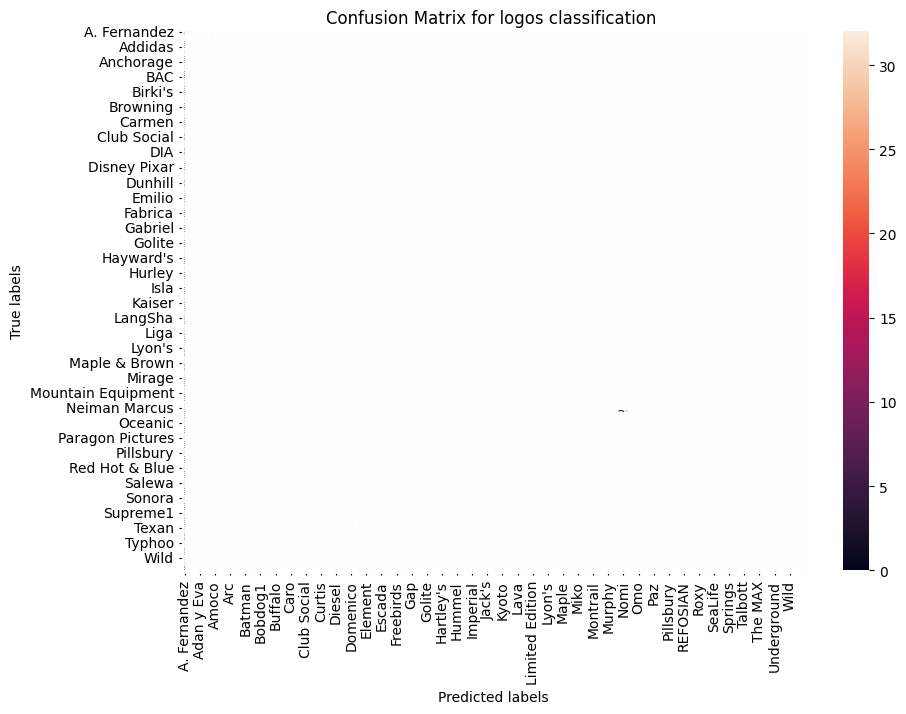

In [45]:
# Build confusion matrix
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names], columns = [i for i in class_names])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion Matrix for logos classification ")
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(f'{target_dir}/Confusion_Matrix.png')
plt.show()

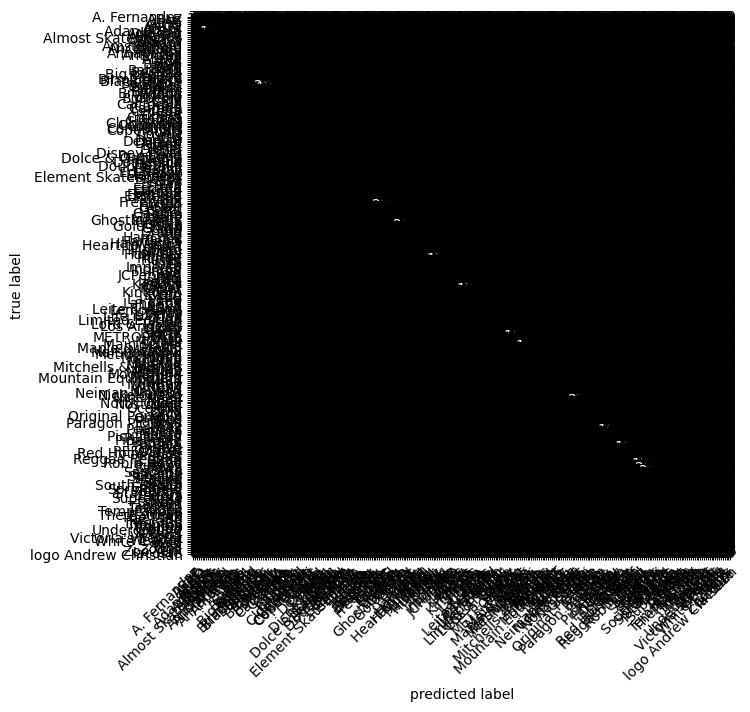

In [46]:
y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred, target=y_true)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib works with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [ ]:
y_pred.size()

In [ ]:
y_true

In [ ]:
cf_matrix

# Load Saved Model

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

#current_exp_dir = 'models/2024-04-24_8:59'
# Load the saved model with custom class number
#model = Resnet18(num_classes=num_classes, pretrained=True, fine_tune=True)
#model.load_state_dict(torch.load(f'{target_dir}/resnet_best.pth'))


### USE MODEL OR NEW_MODEL 
# Create a new model and adjust its final layer
new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Sequential(
    nn.Linear(new_model.fc.in_features, num_classes),
    nn.Sigmoid()
)
# Correctly copy the weights and biases from the loaded model to the new model
#new_model.fc[0].weight.data = model.fc[0].weight.data.clone()
#new_model.fc[0].bias.data = model.fc[0].bias.data.clone()

### Get some images from the Dataset

### Evaluation 

## Clasification on unseen Image

In [ ]:
# Load and preprocess the unseen image
image_path = 'img/boeing_img000019_34_0.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_batch.to(device))

# Get the predicted class
_, predicted_class = output.max(1)
# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

In [ ]:
class_names[155]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.text(1 , 1 ,f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()

In [ ]:
with open("Datasets/brands.txt", "r") as file:
    lines = file.readlines()

lines_upper = [line.upper() for line in lines]

unique_lines = set()
duplicate_lines = []

for line in lines_upper:
    if line in unique_lines:
        duplicate_lines.append(line)
    else:
        unique_lines.add(line)
print(f'{len(unique_lines)} Brands')